In [1]:
'''
SCRIPT PER PROVARE configurazioni SVM
'''

import time
t_orig = time.process_time()
last_time = 0

import warnings
#warnings.simplefilter("ignore")

import codecs
import csv
import argparse
import os
import numpy as np
import pickle
import pandas as pd

from dill import dill
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, classification_report
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import cross_validation, svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree.tree import DecisionTreeClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# modulo per confrontare il risultato delle regex
# richiede entrambi i db già etichettati
import tortellino_parmigiano 
import crea_db


import evaluation_report # stampa confusion_matrix e altro
from text_tokenizer import get_tokenizer 
from nltk.stem.snowball import ItalianStemmer

/home/utente_locale/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
ita_stopwords = set(stopwords.words('italian'))
ita_stemmer = ItalianStemmer()
ita_stemming = ita_stemmer.stem
def get_tokenizer1(doc): #(word_ngrams=None, char_ngrams=None, stopwords=None, additional_extractors=None):
    # rimuove le stopwords
    doc = filter(lambda x: x not in ita_stopwords, word_tokenize(doc))
    # stemma le parole
    doc = [ita_stemmer.stem(a) for a in doc]
    return doc

def get_tokenizer(doc): #(word_ngrams=None, char_ngrams=None, stopwords=None, additional_extractors=None):
    doc = filter(lambda x: x not in ita_stopwords, word_tokenize(doc))
    #doc = map(ita_stemming, doc)
    #doc = [ita_stemmer.stem(a) for a in doc]
    temp = ''
    for par in doc:
        temp = '{} {}'.format(temp, ita_stemming(par))
    return temp

In [3]:
DATA_FOLDER = "/home/backup/dati_e_csv/" # DATI
# ci assicuriamo siano presenti i DB
training_db_name = crea_db.build_training(OUTPUT=DATA_FOLDER)
test_db_name = crea_db.build_test(OUTPUT=DATA_FOLDER) ################################
PATH = '/home/backup/dati_e_csv/training_stemmed.pickle'
    
# carica il pickle 
if os.path.exists(PATH):
    print('Trovato salvataggio training set')
    salvataggio = pd.read_pickle(PATH)
    etichette = salvataggio[
        salvataggio.columns.difference(['testo', 'testo_stemmato'])].columns.values.tolist()
    print('Salvataggio caricato')
else:
    print('Creo il training set')
    
    texts = list()
    labels = list()
    names= []

    # load training dataset # possiamo usare sqlite
    with codecs.open(os.path.join(DATA_FOLDER, training_db_name), 'r', errors='ignore') as file:
        reader = csv.reader(file, delimiter=';')
        etichette = next(reader)
        for row in reader:
            # load documents
            #concatena il testo cliente con operatore
            unito = (row[11].replace('#O:', '')+row[12]).replace('#C:', '') 
            texts.append(unito)
            # load row name
            names.append(row[10])
            # load labels
            labels.append(list(map(lambda x: int(x), row[:10])))

    print('dimensioni:',len(texts), len(labels))
    # tokenization function # possiamo usare anche solo un canale cliente/operatore
    print('Inizio lo stemming')
    etichette = etichette[:10]
    salvataggio = pd.DataFrame()
    salvataggio['testo'] = texts
    salvataggio[etichette] = pd.DataFrame(Y)
    salvataggio['testo_stemmato'] = pd.Series(list(map(get_tokenizer, texts)))
    print('Training set creato e salvato')
    
    # save DataFrame
    salvataggio.to_pickle(PATH)

Training sqlite e csv presenti!
Test sqlite e csv presenti!
Trovato salvataggio training set
Salvataggio caricato


In [4]:
salvataggio[salvataggio.columns.difference(['testo', 'testo_stemmato'])].columns.values.tolist()

['attivazione',
 'canone rai',
 'cessazione',
 'contratto',
 'credito',
 'domiciliazione',
 'fatturazione',
 'gr-invito a chiamare - focus',
 'non di competenza',
 'richiamate']

In [6]:
estimator = BaggingClassifier(base_estimator=LinearSVC(C=20), n_estimators=6, 
                              # crea 6 estimator per ogni classe
                              max_samples=0.001,
                        max_features=0.5, bootstrap=True, bootstrap_features=True,
                        n_jobs=-1, verbose=5)

algo = OneVsRestClassifier(estimator, n_jobs=1)

# pipeline definition
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer='word',
                             max_df=0.6,min_df=0,max_features=1000)),# feature extraction,
    ('tfidf', TfidfTransformer(use_idf=True)), # weighting
    ('clf', algo) # learning algorithm
])

# parameters = {#'vect__ngram_range': ((1, 1),(1, 2)),
#               #'vect__max_df': (0.5,0.75,1.0),
#               #'vect__min_df': (0,0.25,0.4),
#               #'vect__max_features': (None,50,500,1000, 5000), 
#               #'tfidf__use_idf': (True,False),
#               #'tfidf__smooth_idf': (True,False)
#               'clf__estimator__C': (15,18,20),
#               #'clf__estimator__penalty': ('l1','l2')
#              } # vuole min e max --> facciamo unigrammi e bigrammi



# gs = GridSearchCV(pipeline, parameters, scoring='f1_macro', n_jobs=-1, verbose=10)


#print('Pipeline creata, avvio il modello')

print('Algoritmo pronto per essere fittato')

Algoritmo pronto per essere fittato


In [7]:
salvataggio.head()

,testo,attivazione,canone rai,cessazione,contratto,credito,domiciliazione,fatturazione,gr-invito a chiamare - focus,non di competenza,richiamate,testo_stemmato
0,sono geloso macchina perché che questo mi ...,0,0,0,0,1,0,0,1,0,0,gelos macchin dann numer nient quand prossim ...
1,sì hanno hanno inviato documentazioni fonte...,0,0,0,0,0,0,0,1,0,0,sì invi document font signor numer client ved...
2,io la sento malissimo sì ma la bolletta il...,0,0,0,0,0,0,0,0,0,0,sent malissim sì bollett numer civic dic codi...
3,spetti si senta lei si esprime ma il moti...,0,0,0,0,1,0,0,1,0,1,spett sent esprim mot collett dic volt chiam ...
4,sì per attivare che il contratto segnalasse...,0,0,0,0,0,0,0,1,0,0,sì attiv contratt segnal ' abit richiest può ...


Grid Search celle larghe:

Best score: 0.464

Best parameters set:

clf__estimator__C: 1

tfidf__use_idf: True

vect__max_df: 0.5

vect__max_features: 1000

GRID SEARCH 2:

done in 822.022s
Best score: 0.488
Best parameters set:
	clf__estimator__C: 1.5
	vect__max_df: 0.5
	vect__max_features: 1500
    
GRID SEARCH 3:
done in 935.240s
Best score: 0.480
Best parameters set:
	clf__estimator__C: 10
	vect__max_features: 2500
	vect__min_df: 0
    
    
GS 4:
Best score: 0.488
Best parameters set:
	clf__estimator__C: 9
	vect__max_df: 0.5
	vect__max_features: 1500
	vect__min_df: 0


Best score: 0.471
Best parameters set:
	clf__estimator__C: 12
    
done in 1479.661s
Best score: 0.473
Best parameters set:
	clf__estimator__C: 18
    
done in 1254.545s
Best score: 0.481
Best parameters set:
	clf__estimator__C: 18

In [ ]:
#Grid search gia' eseguita

print('grid search in action...')
t0 = time()
gs.fit(texts, Y)
print("done in %0.3fs" % (time() - t0))
print("Best score: %0.3f" % gs.best_score_)
print("Best parameters set:")
best_parameters = gs.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [63]:
salvataggio['testo_stemmato'].loc[train]

(24379,)

In [20]:
print(salvataggio[etichette].shape)
print(salvataggio['testo_stemmato'].shape)

(24379, 10)
(24379,)


In [8]:
# controlla se esiste il modello per evitare di ricrearlo ogni volta
if True: #os.path.exists(os.path.join(DATA_FOLDER, 'bagging.model')):
    with open(os.path.join(DATA_FOLDER, 'bagging.model'), mode='rb') as modelfile:
        model = dill.load(modelfile)

else:
    # cambiare testo_stemmato con testo
    model = pipeline.fit(salvataggio.testo_stemmato, salvataggio[etichette])
    print('Modello creato, verifico il test set')


    with open(os.path.join(DATA_FOLDER, 'bagging.model'), mode='wb') as modelfile:
        dill.dump(model, modelfile)
        
print('Time to load/create the model: ', time.process_time()-last_time)
last_time = time.process_time()

Time to load/create the model:  5.892895391


In [9]:
import time
print('Time to load create the model: ', time.process_time()-last_time)
last_time = time.process_time()

Time to load create the model:  0.009707974000000341


In [10]:
# importo il test set per la valutazione del modello
unito_test = []
#label_names = []
test_texts = list()
test_labels = list()
#raise SystemExit

# load test data
# carica il test set
with codecs.open(os.path.join(DATA_FOLDER, test_db_name), 'r', errors='ignore') as file:
    reader = csv.reader(file, delimiter=';')
    etichette = next(reader)[3:]
    #print(etichette)
    for row in reader:
        # load documents
        test_texts.append((row[1]+row[2]).replace('O:', '').replace('C:', ''))
        # load names
        #names_test.append(row[0])
        # load labels
        test_labels.append(list(map(lambda x: int(x),row[-10:])))
        
print('test set caricato')

test set caricato


In [11]:
# VALIDATION
Y_validation = np.array(test_labels)
########### CORRECT IF TRAINING IS STEMMED OR NOT
X_validation = list(map(get_tokenizer, test_texts))

#prediction = np.zeros((Y_validation.shape[0], Y_validation.shape[1], len(models_cv)))


prediction = model.predict(X_validation)
    
#prediction = np.sum(prediction, axis = 2)/n_splits

print(classification_report(Y_validation, prediction, target_names=etichette))


print('Time to validate: ', time.process_time()-last_time)
last_time = time.process_time()

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]

                              precision    recall  f1-score   support

                 attivazione       0.44      0.11      0.18        73
                  canone rai       1.00      0.13      0.23        63
                  cessazione       0.00      0.00      0.00        10
                   contratto       0.73      0.15      0.25        74
                     credito       0.61      0.88      0.72       162
              domiciliazione       0.00      0.00      0.00        21
                fatturazione       0.50      0.17      0.25       124
gr-invito a chiamare - focus       0.08      0.74      0.14        23
           non di competenza       0.00      0.00      0.00        50
                  richiamate       0.00      0.00      0.00         3

                 avg / total       0.52      0.34      0.33       603

Time to validate:  10.156759047999998


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
/home/utente_locale/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
#### per il testo NON stemmato

Y_test = np.array(test_labels)
# apply model to data
predicted_labels = model.predict(test_texts) #np_array 

print(Y_test.shape)
# print evaluation report
evaluation_report.print_evaluation(Y_test, predicted_labels)
for i in range(predicted_labels.shape[1]):
    print(etichette[i], np.sum(predicted_labels[:,i]))
print('Decision function: ')

scores = model.decision_function(test_texts) #np_array

print('\n')
print('accuracy', accuracy_score(Y_test, predicted_labels))
print('precision micro',precision_score(Y_test, predicted_labels, average='micro') )
print('recall micro',recall_score(Y_test, predicted_labels, average='micro'))
print('f1 micro', f1_score(Y_test, predicted_labels, average='micro'))
print('precision macro', precision_score(Y_test, predicted_labels, average='macro') )
print('recall macro', recall_score(Y_test, predicted_labels, average='macro'))
print('f1 macro', f1_score(Y_test, predicted_labels, average='macro'))


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]

(424, 10)
[[0 1 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 0 1 0 0 0]
 [1 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Confusion matrix attivazione
[[351   0]
 [ 73   0]]
Confusion matrix canone rai
[[361   0]
 [ 63   0]]
Confusion matrix cessazione
[[414   0]
 [ 10   0]]
Confusion matrix contratto
[[350   0]
 [ 74   0]]
Confusion matrix credito
[[262   0]
 [162   0]]
Confusion matrix domiciliazione
[[403   0]
 [ 21   0]]
Confusion matrix fatturazione
[[300   0]
 [124   0]]
Confusion matrix gr-invito a chiamare - focus
[[401   0]
 [ 23   0]]
Confusion matrix non di competenza
[[374   0]
 [ 50   0]]
Confusion matrix richiamate
[[421   0]
 [  3   0]]
                              precision    recall  f1-score   support

                 attivazione       0.00      0.00      0.00        73
                  canone rai       0.00      0.00      0.00        63
         

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]



accuracy 0.00471698113208
precision micro 0.0
recall micro 0.0
f1 micro 0.0
precision macro 0.0
recall macro 0.0
f1 macro 0.0


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
/home/utente_locale/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/utente_locale/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/utente_locale/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/utente_locale/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetri

In [13]:
# score della cat credito 
cred_score = scores[:,4]
cred_pred = predicted_labels[:,4]
#print(len(cred_score), cred_pred)

positive = cred_score[cred_pred == 1]
neg = cred_score[cred_pred == 0]
#print(positive)
print('media score positivi predetti:   ', positive.mean())
print('media score negativi predetti:   ', neg.mean())
print('std score positivi predetti:     ', positive.std())
print('std score negativi predetti:     ', neg.std())

media score positivi predetti:    nan
media score negativi predetti:    -0.733378941018
std score positivi predetti:      nan
std score negativi predetti:      0.240482342279


/home/utente_locale/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/utente_locale/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utente_locale/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/utente_locale/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utente_locale/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
# confronto gli score dei doc annotati a mano con quelli assegnati dal modello
cred_score = scores[:,4]
cred_ammano = Y_test[:,4]
#print(len(cred_score), cred_ammano)

positive_ammano = cred_score[cred_ammano == 1]
neg_ammano = cred_score[cred_ammano == 0]
print(sum(cred_ammano), len(positive_ammano))
print('media score positivi:   ' , positive_ammano.mean())
print('media score negativi:   ', neg_ammano.mean())
print('std score positivi:     ', positive_ammano.std())
print('std score negativi:     ', neg_ammano.std())

162 162
media score positivi:    -0.6484994815
media score negativi:    -0.785861660262
std score positivi:      0.236009619202
std score negativi:      0.227904347107


In [17]:
# confronto gli error rate per ciascuna classe
# predico il training set
Y_pred_train = model.predict(X_validation)

accuracy_test = []
accuracy_train = []
for i in range(predicted_labels.shape[1]):
    accuracy_test.append(accuracy_score(Y_test[:,i], predicted_labels[:,i]))
    accuracy_train.append(accuracy_score(Y_validation[:,i], Y_pred_train[:,i]))
    

print ('error rate:')
print('{:>35} {:>10}'.format('test','train'))
for n in range(len(etichette[:10])):
      print('{:>23}{:>12}{:>10}'.format(etichette[n], round(1-accuracy_test[n],3), round(1-accuracy_train[n],3)))
    
print('''
    COME INTERPRETARE:
    
    Training error is low but is much lower than testing error - overfitting
    Both errors are low - ok
    Both errors are high - underfitting
    Training error is high but testing is low - error in implementation or very small dataset
''')

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]

error rate:
                               test      train
            attivazione       0.172     0.177
             canone rai       0.149      0.13
             cessazione       0.024     0.024
              contratto       0.175     0.158
                credito       0.382     0.264
         domiciliazione        0.05      0.05
           fatturazione       0.292     0.292
gr-invito a chiamare - focus       0.054     0.507
      non di competenza       0.118      0.12
             richiamate       0.007     0.009

    COME INTERPRETARE:
    
    Training error is low but is much lower than testing error - overfitting
    Both errors are low - ok
    Both errors are high - underfitting
    Training error is high but testing is low - error in implementation or very small dataset



[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


Riduco le dimensioni


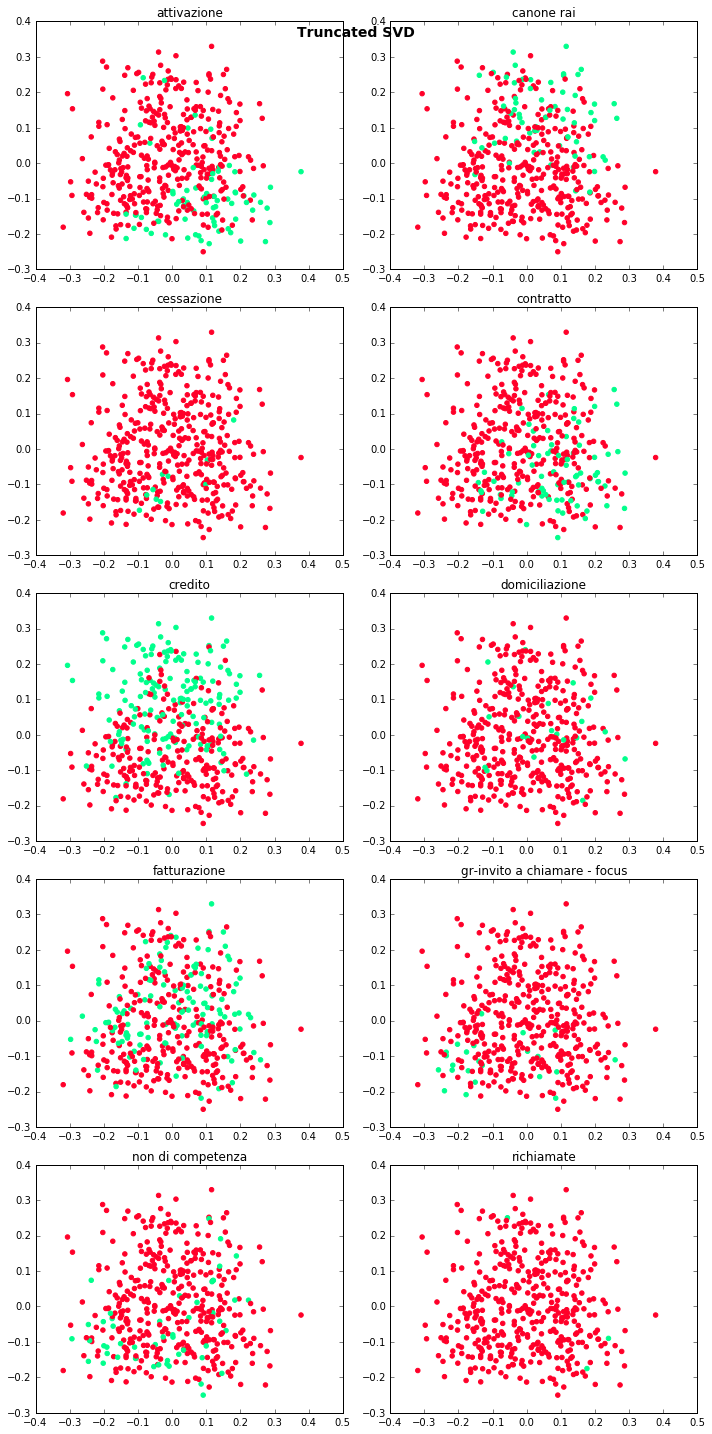

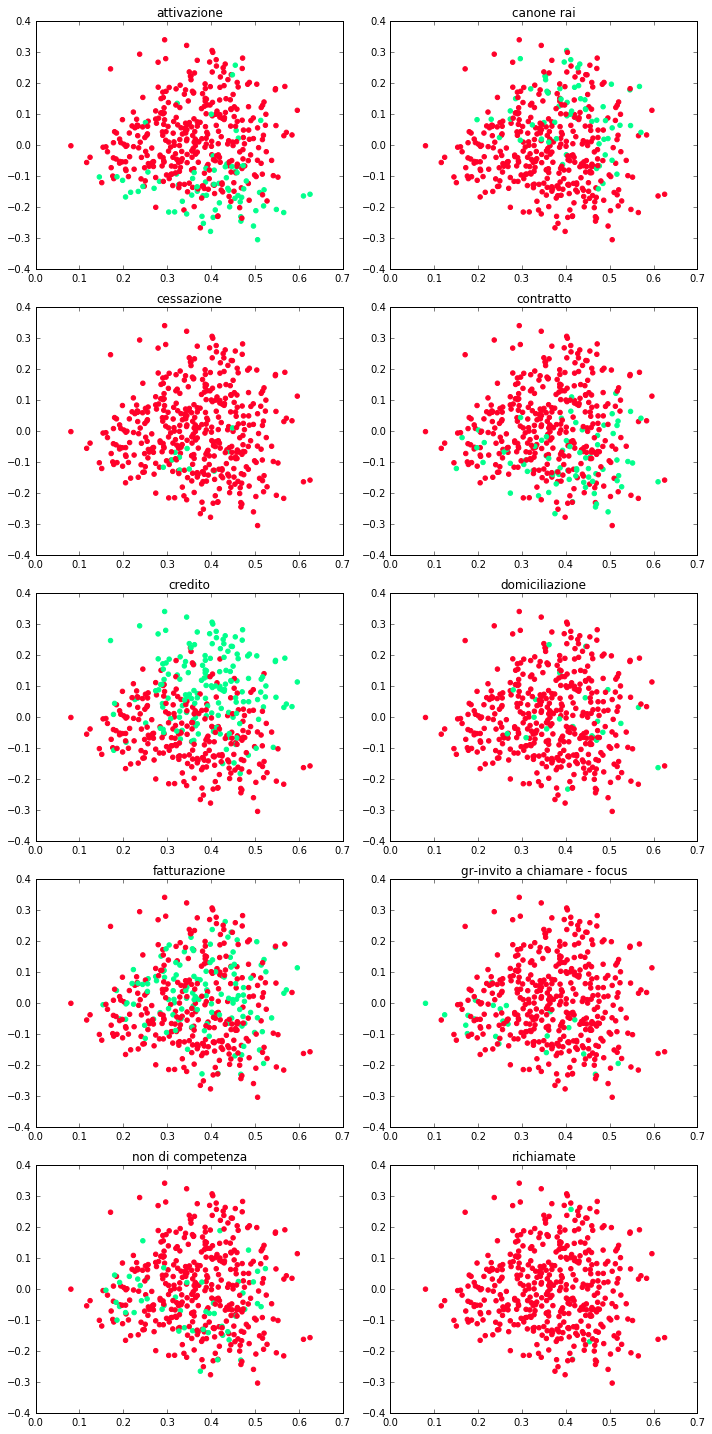

In [34]:
# PLOT

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

# produce visualization
# reduce dimensions
print('Riduco le dimensioni')
reducer = TruncatedSVD() # PCA(n_components=2) #
X = TfidfTransformer(use_idf=True).fit_transform(
                    CountVectorizer(analyzer='word', max_df=0.6,
                    min_df=0,max_features=1000).fit_transform(test_texts))

y = reducer.fit_transform(X.toarray())

y = PCA(n_components=2).fit_transform(X.toarray())
y_pca = reducer.fit_transform(X.toarray())

# print('Disegno il grafico')

# labels = Y_test[:,1]
# colors = ['blue', 'red']#[cm.gist_rainbow(float(label) / 5) for label in labels]

# plotx = y[:, 0]
# ploty = y[:, 1]

# fig = plt.figure()

# # 2d plot
# subplot = fig.add_subplot(111)
# #subplot.title(k)
# subplot.scatter(plotx, ploty, color=colors)
# if False: # plot labels in graph
#     for id_, x, y in zip(ids, plotx, ploty):
#         subplot.annotate(id_, (x, y))
        
# print('Disegno il grafico')
# reducer = PCA(n_components=2)
# y = reducer.fit_transform(X.toarray())
# labels = Y_test[:,1]
# colors = ['blue', 'red']#[cm.gist_rainbow(float(label) / 5) for label in labels]

# plotx = y[:, 0]
# ploty = y[:, 1]

# fig = plt.figure()

# # 2d plot
# subplot = fig.add_subplot(111)
# #subplot.title(k)
# subplot.scatter(plotx, ploty, color=colors)
# if False: # plot labels in graph
#     for id_, x, y in zip(ids, plotx, ploty):
#         subplot.annotate(id_, (x, y))

# assign a color to each label
#print('Disegno il grafico')
fig = plt.figure(figsize=(10,20))
fig.suptitle('Truncated SVD', fontsize=14, fontweight='bold')
for i, k in enumerate(etichette):
    labels = Y_test[:,i]
    colors = [cm.gist_rainbow(float(label) / 2.) for label in labels]

    plotx = y[:, 0]
    ploty = y[:, 1]

    # 2d plot
    subplot = fig.add_subplot(5,2,i+1)
    #subplot.title(k)
    subplot.set_title(etichette[i])
    subplot.scatter(plotx, ploty, color=colors)
    if False: # plot labels in graph
        for id_, x, y in zip(ids, plotx, ploty):
            subplot.annotate(id_, (x, y))
            
plt.tight_layout()
plt.show()
fig1 = plt.figure(figsize=(10,20))
fig1.suptitle('PCA', fontsize=14, fontweight='bold')
for i, k in enumerate(etichette):
    labels = Y_test[:,i]
    colors = [cm.gist_rainbow(float(label) / 2.) for label in labels]

    plotx = y_pca[:, 0]
    ploty = y_pca[:, 1]

    # 2d plot
    subplot = fig1.add_subplot(5,2,i+1)
    subplot.set_title(etichette[i])
    #subplot.title(k)
    subplot.scatter(plotx, ploty, color=colors)
    if False: # plot labels in graph
        for id_, x, y in zip(ids, plotx, ploty):
            subplot.annotate(id_, (x, y))
            
plt.tight_layout()
plt.show()